In [1]:
from netgen.occ import *
from ngsolve import *
from netgen.meshing import IdentificationType
from MS_helper_functions import *
from netgen.webgui import Draw as DrawGeo
from ngsolve.webgui import Draw
#Draw = lambda *args, **kwargs : None

import matplotlib.pyplot as plt
%matplotlib widget
plt.ioff()

from myPackage import evalOnLine


from meshGen import mesh2DLaminates

In [32]:
lambda1 = 1
lambda2 = 100

order0 = 2

In [33]:
D = 0.04
d = 0.02

ff = 0.7


numSheets = 4

maxh_edges = d/numSheets*1/2 * 0.1







## 2. Only Rough
### 2.1. Reference Solution Only Rough

In [34]:
cMeshRef = mesh2DLaminates(D, d, ff, numSheets, multiscale=False, onlyRough=True, maxh_edges=maxh_edges, fullProblemX=True, rotated=True, modelHalfAir=True, quad_dominated=False)
meshRef = cMeshRef.mesh
print("Boundaries", set(meshRef.GetBoundaries()))
print("Materials", set(meshRef.GetMaterials()))
Draw(meshRef.ngmesh)

maxh_edges [0.00025, 0.00025]
Boundaries {'ileft', 'top', 'right', 'itop', 'bottom', 'left', 'iright', 'ibottom', 'default'}
Materials {'inner', 'insulation', 'outer'}


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'mesh_dim': 2, 'mesh_cent…

BaseWebGuiScene

In [35]:
lam = meshRef.MaterialCF({"inner":lambda2, "outer":lambda1, "insulation":lambda1, "gap":lambda1, "multiscale":lambda2})
def calcRef():
    fes = H1(meshRef, order=order0, dirichlet="left|right")

    u,v = fes.TnT()
    sol = GridFunction(fes)

    a = BilinearForm(fes, symmetric=True)
    f = LinearForm(fes)

    a += lam * grad(u) * grad(v) * dx

    prec = Preconditioner(a, "direct")


    sol.Set(1 * x/Norm(x), BND)
    solvers.BVP(bf = a, lf= f, pre=prec, gf=sol, maxsteps=10)
    
    
    energy =  Integrate( InnerProduct(lam * grad(sol), grad(sol)), meshRef, definedon=meshRef.Materials("inner|insulation"))
    
    return sol, energy

sol_ref, energy_ref = calcRef()


CG iteration 1, residual = 3.0486682138373173     
CG iteration 2, residual = 1.3150796201510078e-14     


In [36]:


print(f"energy:\t{energy_ref}")
Draw(sol_ref, settings={"Objects":{"Wireframe":True}, "deformation": 0.01})
Draw( Norm(-grad(sol_ref)), meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False})


energy:	0.07047661718288796


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Tru…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

BaseWebGuiScene

### 2.2 Multiscale only Rough

In [31]:
import cempy as cp
modelHalfAir=True
cMeshMS = mesh2DLaminates(D, d, ff, numSheets, multiscale=True, modelHalfAir=modelHalfAir, domainNameHalfAir="multiscale", onlyRough=True,  maxh_edges=[maxh_edges*20, maxh_edges*5], rotated=True, modelGap=True)
# cMeshMS = mesh2DLaminates(D, d, ff, numSheets, multiscale=True, modelHalfAir=modelHalfAir, domainNameHalfAir="smoothFrame", onlySmooth=onlySmooth)
meshMS = cMeshMS.mesh
print(meshMS.GetMaterials())
Draw(meshMS.ngmesh)


# from myPackage import drawBndAll
# drawBndAll(meshMS, drawFunc=Draw, block=False)


maxh_edges [0.005, 0.00125]
('multiscale', 'gap', 'gap')


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'mesh_dim': 2, 'mesh_cent…

BaseWebGuiScene

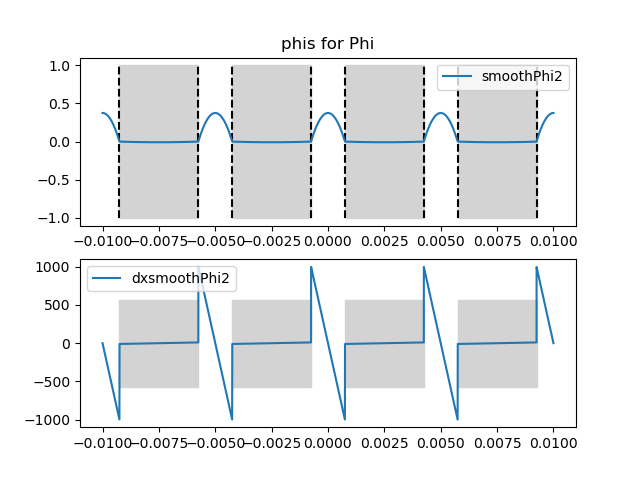

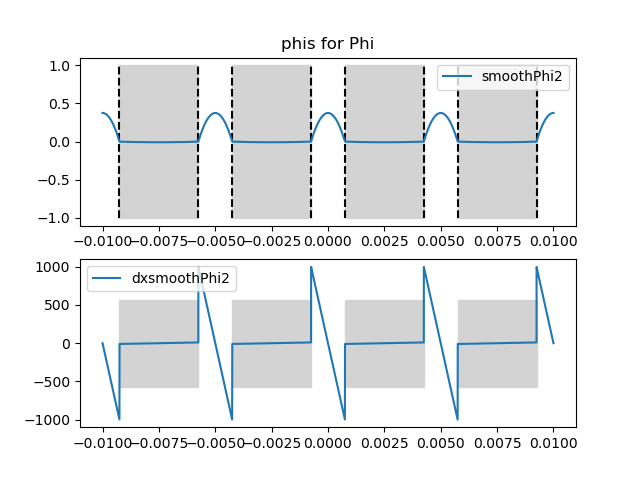

CG iteration 1, residual = 2.1615156265573576     
CG iteration 2, residual = 5.881498698415517e-15     
anorm 2668.1386991715635
energy 0.05964539985171903 0.07047661718288796
7.966216479464503e-07
-grad(Phi0_outer) - grad(Phi1 * smoothPhi2)


In [37]:
cl_Phi.numSheets = numSheets
cl_Phi.dFe = cMeshMS.dFe
cl_Phi.d0 = cMeshMS.d0
cl_Phi.mesh = meshMS

cl_Phi.modelHalfAir = modelHalfAir
cl_Phi.orientation = 1


if False:
    from cempy.phiFunctions import Lobatto, dxLobatto
    cl_Phi.phiFunction = Lobatto
    cl_Phi.dzPhiFunction = dxLobatto



smooth_fun_Fe = lambda x: 1e3 * lambda1/lambda2 * (x**2/cl_Phi.dFe * 1 - (cl_Phi.dFe/4 * 1))
smooth_fun_0 = lambda x: 1e3*(-(x - (cl_Phi.d0/2+cl_Phi.dFe/2))**2/ cl_Phi.d0 * 1 + cl_Phi.d0/4 * 1)


smoothPhi2 = pyPhiFunction(cl_Phi.getZStart(), cl_Phi.getD(), [smooth_fun_Fe, smooth_fun_0], numSheets, ff, cl_Phi.orientation, name = "smoothPhi2")

force_full_Phi = True
moartaring = False



def calcMultiscale(useGradients=True, drawPhis=True):

    smoothbnd = "itop|ibottom"
    # microshape functions
    orderPhi = [
            cl_Phi(0, fes_order=1, material="multiscale|gap", dirichlet="left|right", useGradients=True, useAbsolutes=False), 
            # cl_Phi(1, fes_order=order0, material="multiscale|gap", dirichlet="left|right", useGradients=False), 
# 
            # cl_Phi(2, fes_order=2, material="multiscale|gap", dirichlet="left|right", useGradients=True, inAir=False, modelHalfAir=True), 
            # cl_Phi(2, fes_order=2, material="multiscale|gap", dirichlet="left|right", useGradients=True, inIron=False, modelHalfAir=True), 

            cl_Phi([smoothPhi2, smoothPhi2.getDiff()], fes_order=2, material="multiscale|gap", dirichlet="left|right", useGradients=True, inIron=False, modelHalfAir=True),
            # cl_Phi(1, fes_order=order0, material="multiscale", dirichlet="left|right", inAir=False, useGradients=True), 
            # cl_Phi(1, fes_order=order0, material="multiscale", dirichlet="left|right", inIron=False, useGradients=useGradients), 
            # cl_Phi(2, fes_order=order0, material="multiscale", dirichlet="left|right", inAir=False, modelHalfAir=True, useGradients=True), 
            # cl_Phi(2, fes_order=order0, material="multiscale", dirichlet="left|right", inIron=False, modelHalfAir=False, useGradients=useGradients), 
        ]


    if not moartaring:
        orderPhi = orderPhi[1:]

    if drawPhis:
        cl_Phi.plotEvaluated(orderPhi)
        cl_Phi.plotDirectEvaluated(orderPhi)



    VSpace = []
    # u0 
    domains_outer = "outer"
    if not moartaring:
        domains_outer += "|multiscale|gap"
    VSpace.append(H1(meshMS, order=order0, dirichlet="left|right", definedon=meshMS.Materials(domains_outer))) 
    
        
    # ui * phi i
    for phi_i in orderPhi: 
        VSpace.append(H1(meshMS, order=phi_i.fes_oder, definedon=meshMS.Materials(phi_i.material), dirichlet=phi_i.dirichlet))
    VSpace = FESpace(VSpace)


    # multiscale container
    ansatz = ""
    sol = GridFunction(VSpace, "sol")
       

    cl_gradgradMS = gradgradMS(orderPhi, sol, addPhi0Outer=True)

    cl_gradgradMS.generateCouplingMatrix(lambda2, lambda1, force_full_Phi=force_full_Phi)

    # for phi_a in cl_gradgradMS.coupling_matrix.keys():
    #     for phi_b in cl_gradgradMS.coupling_matrix[phi_a].keys():
    #         if (phi_a.order == 1 and phi_b.order == 2) or (phi_a.order == 2 and phi_b.order == 1):
    #             cl_gradgradMS.coupling_matrix[phi_a][phi_b] = 0



    a = BilinearForm(VSpace, symmetric=True)
    f = LinearForm(VSpace)

    # a += lambda1  * grad(cl_gradgradMS.trials[0]) * grad(cl_gradgradMS.tests[0]) * dx("outer")
    a += getIntegrand4BFI(cl_gradgradMS.gradu, cl_gradgradMS.gradv, lambda2, lambda1, force_full_Phi=True, modelHalfAir=False) \
                    * dx("multiscale")
    a += getIntegrand4BFI(cl_gradgradMS.gradu, cl_gradgradMS.gradv, lambda1, lambda1, force_full_Phi=True, modelHalfAir=False)  \
                    * dx("gap")


    alpha = 3.5
    h = specialcf.mesh_size

    u_start = 1 if moartaring else 0
    alpha = 3
    d_coupling = -d/2 if modelHalfAir else -d/2 + cl_Phi.d0/2


    # absolutes
    u_range = range(u_start, len(cl_gradgradMS.u))
    # u_range = [1]
    um_bottom = sum(cl_gradgradMS.u[i][0] * cl_gradgradMS.u[i][1].DirectEvaluate(-d_coupling) for i in u_range)
    vm_bottom = sum(cl_gradgradMS.v[i][0] * cl_gradgradMS.v[i][1].DirectEvaluate(-d_coupling) for i in u_range)

    um_top = sum(cl_gradgradMS.u[i][0] * cl_gradgradMS.u[i][1].DirectEvaluate(d_coupling) for i in u_range)
    vm_top = sum(cl_gradgradMS.v[i][0] * cl_gradgradMS.v[i][1].DirectEvaluate(d_coupling) for i in u_range)

    jump_u_top = cl_gradgradMS.u[0][0] - um_top
    jump_u_bottom = cl_gradgradMS.u[0][0] - um_bottom

    jump_v_top = cl_gradgradMS.v[0][0] - vm_top
    jump_v_bottom = cl_gradgradMS.v[0][0] - vm_bottom

    # gradients
    grad_range = range(u_start, len(cl_gradgradMS.gradu))
    # grad_range = [1] + list(range(4, len(cl_gradgradMS.gradu)))
    
    gradum_bottom = sum(cl_gradgradMS.gradu_trace_n[i][0] * cl_gradgradMS.gradu_trace_n[i][1].DirectEvaluate(-d_coupling) for i in grad_range)
    gradvm_bottom = sum(cl_gradgradMS.gradv_trace_n[i][0] * cl_gradgradMS.gradv_trace_n[i][1].DirectEvaluate(-d_coupling) for i in grad_range)

    gradum_top = sum(cl_gradgradMS.gradu_trace_n[i][0] * cl_gradgradMS.gradu_trace_n[i][1].DirectEvaluate(d_coupling) for i in grad_range)
    gradvm_top = sum(cl_gradgradMS.gradv_trace_n[i][0] * cl_gradgradMS.gradv_trace_n[i][1].DirectEvaluate(d_coupling) for i in grad_range)

    jump_Bu_top = lambda1 * cl_gradgradMS.gradu_trace_n[0][0] - lambda2 * gradum_top
    jump_Bu_bottom = lambda1 * cl_gradgradMS.gradu_trace_n[0][0] - lambda2 * gradvm_bottom

    jump_Bv_top = lambda1 * cl_gradgradMS.gradv_trace_n[0][0] - lambda2 * gradvm_top
    jump_Bv_bottom = lambda1 * cl_gradgradMS.gradv_trace_n[0][0] - lambda2 * gradvm_bottom

    # couple u
    if False:
        #[u][v]
        # a += alpha*order0**2/h  * cl_gradgradMS.getIntegrand4BFI(cl_gradgradMS.u[u_start:], cl_gradgradMS.v[u_start:],  1, 1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        # a += -alpha*order0**2/h  * cl_gradgradMS.getIntegrand4BFI(cl_gradgradMS.u[u_start:], cl_gradgradMS.v[:1],  1, 1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        # a += alpha*order0**2/h  * cl_gradgradMS.getIntegrand4BFI(cl_gradgradMS.u[:1], cl_gradgradMS.v[:1],  1, 1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        # a += -alpha*order0**2/h  * cl_gradgradMS.getIntegrand4BFI(cl_gradgradMS.u[:1], cl_gradgradMS.v[u_start:],  1, 1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)

        a += alpha*order0**2/h  * (jump_u_top)  * (jump_v_top)  *ds("itop")
        a += alpha*order0**2/h  * (jump_u_bottom)  * (jump_v_bottom)  *ds("ibottom")
        

    if False:
        #{dn u } [ v]
        # a += -cl_gradgradMS.getIntegrand4BFI(cl_gradgradMS.gradu_trace_n[u_start:], cl_gradgradMS.v[u_start:],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        # a += cl_gradgradMS.getIntegrand4BFI(cl_gradgradMS.gradu_trace_n[u_start:], cl_gradgradMS.v[:1],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        # a += cl_gradgradMS.getIntegrand4BFI(cl_gradgradMS.gradu_trace_n[:1], cl_gradgradMS.v[u_start:],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        # a += -cl_gradgradMS.getIntegrand4BFI(cl_gradgradMS.gradu_trace_n[:1], cl_gradgradMS.v[:1],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += (lambda2 * jump_gradu_top)  * (jump_v_top)  *ds("itop")
        a += (lambda2 * jump_gradu_bottom)  * (jump_v_bottom)  *ds("ibottom")


        #[ u] {dn v } 
        # a += -cl_gradgradMS.getIntegrand4BFI(cl_gradgradMS.u[u_start:], cl_gradgradMS.gradv_trace_n[u_start:],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        # a += cl_gradgradMS.getIntegrand4BFI(cl_gradgradMS.u[u_start:], cl_gradgradMS.gradv_trace_n[:1],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        # a += cl_gradgradMS.getIntegrand4BFI(cl_gradgradMS.u[:1], cl_gradgradMS.gradv_trace_n[u_start:],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        # a += -cl_gradgradMS.getIntegrand4BFI(cl_gradgradMS.u[:1], cl_gradgradMS.gradv_trace_n[:1],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += (lambda2 * jump_gradv_top)  * (jump_u_top)  *ds("itop")
        a += (lambda2 * jump_gradv_bottom)  * (jump_u_bottom)  *ds("ibottom")

    # couple fluxes
    if False:
        # [dn u] [ dn v]
        # a += alpha*order0**2/h  * cl_gradgradMS.getIntegrand4BFI(cl_gradgradMS.gradu_trace_n[u_start:], cl_gradgradMS.gradv_trace_n[u_start:],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        # a += -alpha*order0**2/h  * cl_gradgradMS.getIntegrand4BFI(cl_gradgradMS.gradu_trace_n[u_start:], cl_gradgradMS.gradv_trace_n[:1],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        # a += alpha*order0**2/h  * cl_gradgradMS.getIntegrand4BFI(cl_gradgradMS.gradu_trace_n[:1], cl_gradgradMS.gradv_trace_n[:1],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        # a += -alpha*order0**2/h  * cl_gradgradMS.getIntegrand4BFI(cl_gradgradMS.gradu_trace_n[:1], cl_gradgradMS.gradv_trace_n[u_start:],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)

        a += alpha*order0**2/h  * (jump_Bu_top)  * (jump_Bv_top)  *ds("itop")
        a += alpha*order0**2/h  * (jump_Bu_bottom)  * (jump_Bv_bottom)  *ds("ibottom")


    # couple hesse 
    if False:

        #{gradgrad(u)_n_n } [ dn v]
        a += -cl_gradgradMS.getIntegrand4BFI(cl_gradgradMS.hesse_u_trace_nn, cl_gradgradMS.gradv_trace_n,  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += cl_gradgradMS.getIntegrand4BFI(cl_gradgradMS.hesse_u_trace_nn, [cl_gradgradMS.gradv_trace_n[0]],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += cl_gradgradMS.getIntegrand4BFI([cl_gradgradMS.hesse_u_trace_nn[0]], cl_gradgradMS.gradv_trace_n,  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += -cl_gradgradMS.getIntegrand4BFI([cl_gradgradMS.hesse_u_trace_nn[0]], [cl_gradgradMS.gradv_trace_n[0]],  lambda2, lambda1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)


        #[ dn u] {gradgrad(v)_n_n } 
        a += -cl_gradgradMS.getIntegrand4BFI(cl_gradgradMS.gradu_trace_n, cl_gradgradMS.hesse_v_trace_nn,  lambda2, lambda1, force_full_Phi=True)  *ds(smoothbnd)
        a += cl_gradgradMS.getIntegrand4BFI([cl_gradgradMS.gradu_trace_n[0]], cl_gradgradMS.hesse_v_trace_nn,  lambda2, lambda1, force_full_Phi=True)  *ds(smoothbnd)
        a += cl_gradgradMS.getIntegrand4BFI(cl_gradgradMS.gradu_trace_n, [cl_gradgradMS.hesse_v_trace_nn[0]],  lambda2, lambda1, force_full_Phi=True)  *ds(smoothbnd)
        a += -cl_gradgradMS.getIntegrand4BFI([cl_gradgradMS.gradu_trace_n[0]], [cl_gradgradMS.hesse_v_trace_nn[0]],  lambda2, lambda1, force_full_Phi=True)  *ds(smoothbnd)

    prec = Preconditioner(a,type="direct")  


    # dirichlet boundary values
    sol.components[0].Set(1 * x/Norm(x), BND)
    if moartaring:
        sol.components[1].Set(1 * x/Norm(x), BND)
    
    solvers.BVP(bf = a, lf= f, pre=prec, gf=sol, maxsteps=10)

    print("anorm", a.mat.AsVector().Norm())

    energy =  Integrate(getIntegrand4BFI(cl_gradgradMS.gradsol_pack, cl_gradgradMS.gradsol_pack, lambda2, lambda1), meshMS, 
                                                    definedon=meshMS.Materials("multiscale"))
    
    return sol, cl_gradgradMS.sol_pack, cl_gradgradMS.sol_comp, cl_gradgradMS.gradsol_comp, energy, cl_gradgradMS

    

sol_MS, sol_pack_MS, sol_comp_MS, H_comp, energy_MS, cl_gradgradMS = calcMultiscale(useGradients=False, drawPhis=True)
print("energy", energy_MS, energy_ref)
print(Integrate(Norm(sum(sol_comp_MS) - sol_ref), meshRef))
print(cl_gradgradMS.ansatz)


In [38]:
cl_gradgradMS.generateCouplingMatrix(lambda2, lambda1, force_full_Phi=True)
cl_gradgradMS.printCouplingMatrix();
cl_gradgradMS.checkCouplingMatrxiSymmetric(1e-3)

                  0             1             2
--  ------------  ------------  ------------  ----------
                  pyLobatto(0)  dxsmoothPhi2  smoothPhi2
0   pyLobatto(0)  70.3          0.0           -0.333
1   dxsmoothPhi2  0.0           102333.333    0.0
2   smoothPhi2    -0.333        0.0           0.025


True

In [39]:
print(f"energy:\t{energy_MS}")
Draw(sum(sol_comp_MS), meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False})
Draw( Norm(sum(H_comp))
, meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False})

energy:	0.05964539985171903


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

BaseWebGuiScene

### 1.3 Comparison 

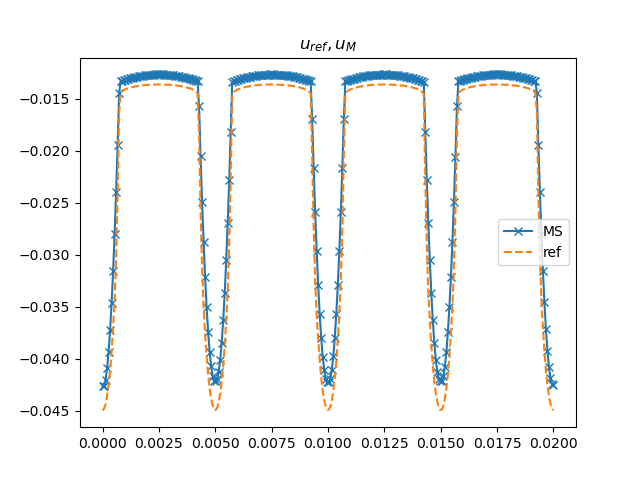

In [40]:

start = -d/2*1.01
end = -d/2*0.9

# start = d/2*0.95
# end = d/2*1.02


plt.figure(2)
start = -d/2
end = d/2




evalOnLine(sum(sol_comp_MS) , meshRef, [-d/2, start, 0], [-d/2, end, 0], plot=True, ls='-', marker="x", clear=True, label="MS", show=False, N=300);
# [evalOnLine(sol_comp_MS[i] , meshRef, [-d/2, start, 0], [-d/2, end, 0], plot=True, ls='-', marker="", clear=False, label="MS_"+sol_pack_MS[i][1].name, show=False, N=1000) for i in range(len(sol_comp_MS))];

evalOnLine(sol_ref , meshRef, [-d/2, start, 0], [-d/2, end, 0], plot=True, ls='--', marker="", show=False, clear=False, label="ref", N = 300, title=r"$u_{ref}, u_{M}$");


plt.legend()
plt.show()

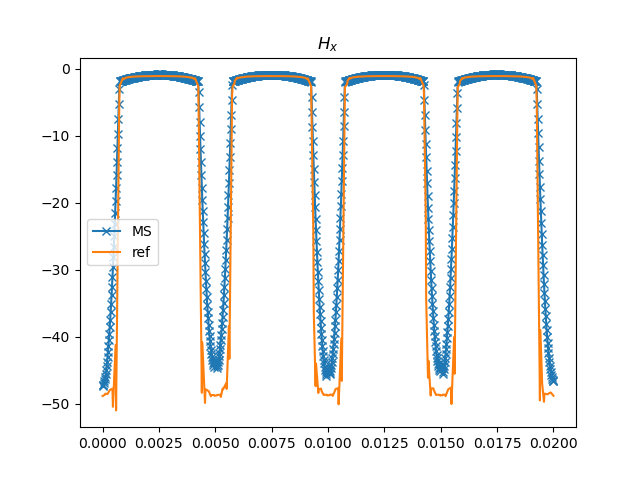

In [41]:
start = -d/2
end = d/2

plt.figure(3)
evalOnLine(sum(H_comp)[0] , meshRef, [-d/2*0.99, start, 0], [-d/2*0.99, end, 0], plot=True, ls='-', marker="x", clear=True, label="MS", show=False, N=1000);
evalOnLine(-grad(sol_ref)[0] , meshRef, [-d/2*0.99, start, 0], [-d/2*0.99, end, 0], plot=True, ls='-', marker="", show=False, clear=False, label="ref", N = 1000, title=r"$H_x$");



plt.legend()
plt.show()

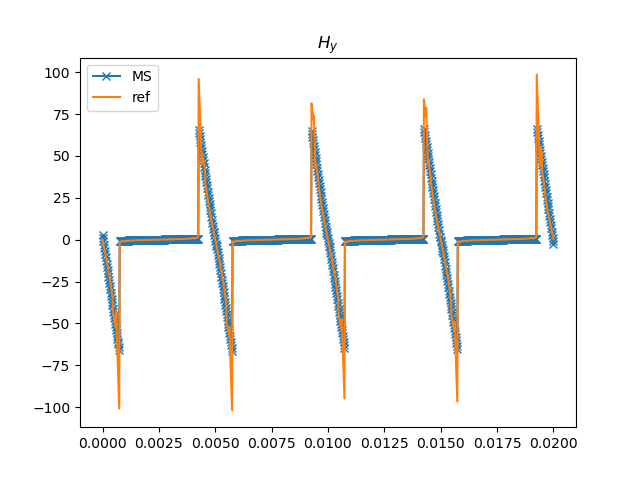

In [42]:
start = -d/2
end = d/2


plt.figure(4)
evalOnLine(sum(H_comp)[1] , meshRef, [-d/2*0.99, start, 0], [-d/2*0.99, end, 0], plot=True, ls='-', marker="x", clear=True, label="MS", show=False, N=1000);
evalOnLine(-grad(sol_ref)[1] , meshRef, [-d/2*0.99, start, 0], [-d/2*0.99, end, 0], plot=True, ls='-', marker="", show=False, clear=False, label="ref", N = 1000, title=r"$H_y$");


plt.legend()
plt.show()

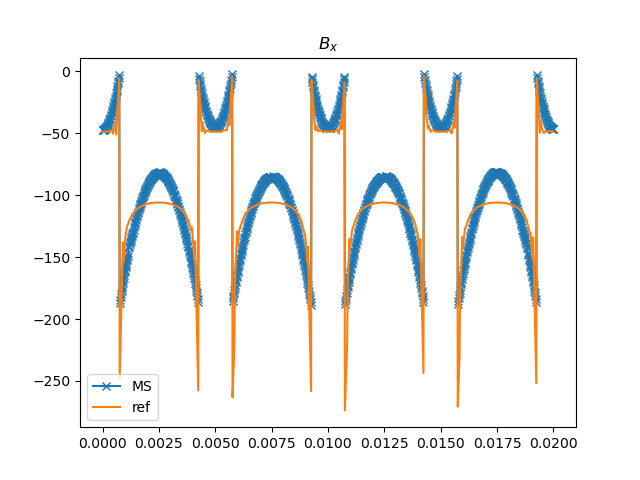

In [43]:
start = -d/2
end = d/2


plt.figure(5)
evalOnLine(lam * sum(H_comp)[0] , meshRef, [-d/2*0.99, start, 0], [-d/2*0.99, end, 0], plot=True, ls='-', marker="x", clear=True, label="MS", show=False, N=1000);
evalOnLine(-lam * grad(sol_ref)[0] , meshRef, [-d/2*0.99, start, 0], [-d/2*0.99, end, 0], plot=True, ls='-', marker="", show=False, clear=False, label="ref", N = 1000, title=r"$B_x$");

plt.legend()
plt.show()

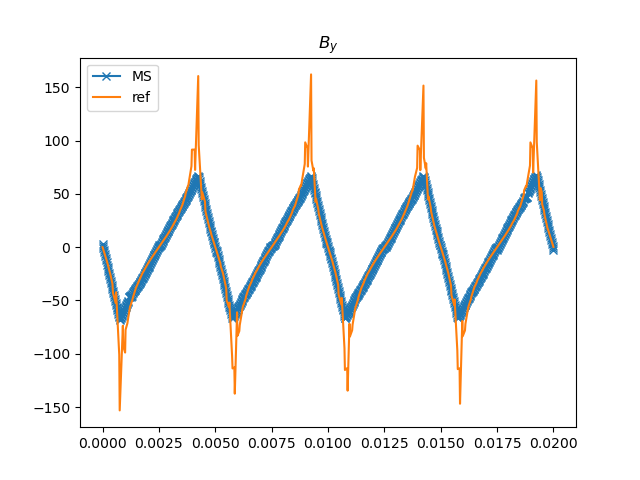

In [44]:
start = -d/2
end = d/2

plt.figure(6)
evalOnLine(lam * sum(H_comp)[1] , meshRef, [-d/2*0.99, start, 0], [-d/2*0.99, end, 0], plot=True, ls='-', marker="x", clear=True, label="MS", show=False, N=1000);
evalOnLine(-lam * grad(sol_ref)[1] , meshRef, [-d/2*0.99, start, 0], [-d/2*0.99, end, 0], plot=True, ls='-', marker="", show=False, clear=False, label="ref", N = 1000, title=r"$B_y$");

plt.legend()
plt.show()

In [45]:
print(f"energy:\t{energy_MS}")
Draw(IfPos(y, sol_ref, sum(sol_comp_MS)), meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False})


energy:	0.05964539985171903


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

BaseWebGuiScene

In [46]:
Draw(IfPos(y, -grad(sol_ref), sum(H_comp))[0], meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False})

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

BaseWebGuiScene

In [18]:
Draw(lam * IfPos(y, -grad(sol_ref), sum(H_comp))[0], meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False},min = -200, max=200)
Draw(lam * IfPos(y, -grad(sol_ref), sum(H_comp))[1], meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False},min = -20, max=20)
lamMS = IfPos(cl_Phi(0, 0, inIron=False, material="multiscale").phi, lambda1, lambda2)

# Draw(lamMS * IfPos(y, -grad(sol_ref), sum(H_comp))[0], meshMS, settings={"Objects":{"Wireframe":False}, "deformation": False},min = -200, max=200)
# Draw(lamMS * IfPos(y, -grad(sol_ref), sum(H_comp))[1], meshMS, settings={"Objects":{"Wireframe":False}, "deformation": False},min = -20, max=20)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

In [19]:
print("Norm soll diff", Integrate(Norm( sol_ref), meshRef), Integrate(Norm(sum(sol_comp_MS) - sol_ref), meshRef))
print("diff energy", energy_MS, energy_ref, energy_MS - energy_ref, )

Norm soll diff 0.00020210182993963478 3.667706222918703e-07
diff energy 0.019176676781898192 0.02196443398840796 -0.0027877572065097694
